# Binary Classification

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

### Device Agnostic Code

In [69]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cpu'

### Data PreProcessing

In [72]:
data = pd.read_csv('./dataset-classification/heart.csv')
data.head()

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0

In [76]:
data['ExerciseAngina'] = data['ExerciseAngina'].replace({'Y':0, 'N': 1})
data['ST_Slope'] = data['ST_Slope'].replace({'Up': 1,'Flat': 0,'Down': -1})
data['Sex'] = data['Sex'].replace({'M':1, 'F':0})
data['RestingECG'] = data['RestingECG'].replace({'Normal':1,'LVH':2,'ST':3})
data['ChestPainType'] = data['ChestPainType'].replace({'ASY':1, 'NAP':2, 'ATA':3, 'TA':4})

data.describe()

Age         Sex  ChestPainType   RestingBP  Cholesterol  \
count  918.000000  918.000000     918.000000  918.000000   918.000000   
mean    53.510893    0.789760       1.748366  132.396514   198.799564   
std      9.432617    0.407701       0.931031   18.514154   109.384145   
min     28.000000    0.000000       1.000000    0.000000     0.000000   
25%     47.000000    1.000000       1.000000  120.000000   173.250000   
50%     54.000000    1.000000       1.000000  130.000000   223.000000   
75%     60.000000    1.000000       2.000000  140.000000   267.000000   
max     77.000000    1.000000       4.000000  200.000000   603.000000   

        FastingBS  RestingECG       MaxHR  ExerciseAngina     Oldpeak  \
count  918.000000  918.000000  918.000000      918.000000  918.000000   
mean     0.233115    1.592593  136.809368        0.595861    0.887364   
std      0.423046    0.793670   25.460334        0.490992    1.066570   
min      0.000000    1.000000   60.000000        0.000000   -2.600000   
25%      0.000000    1.000000  120.000000        0.000000    0.000000   
50%      0.000000    1.000000  138.000000        1.000000    0.600000   
75%      0.000000    2.000000  156.000000        1.000000    1.500000   
max      1.000000    3.000000  202.000000        1.000000    6.200000   

         ST_Slope  HeartDisease  
count  918.000000    918.000000  
mean     0.361656      0.553377  
std      0.607056      0.497414  
min     -1.000000      0.000000  
25%      0.000000      0.000000  
50%      0.000000      1.000000  
75%      1.000000      1.000000  
max      1.000000      1.000000

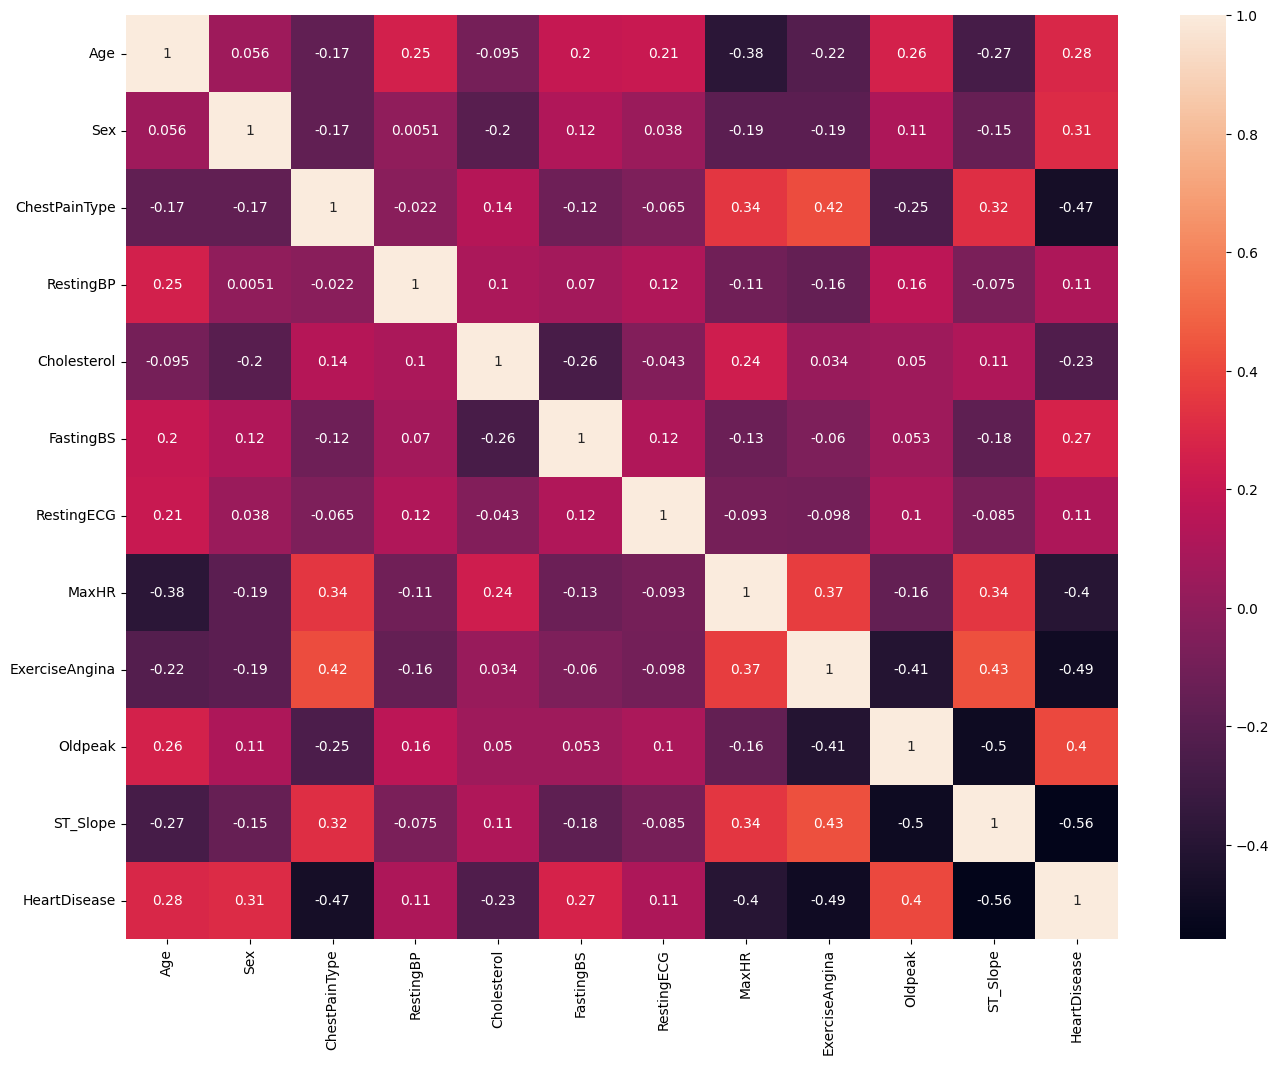

In [78]:
plt.figure(figsize=(16,12))
sns.heatmap(data.corr(), annot=True)
plt.show()

In [80]:
X = data.drop(columns=['HeartDisease', 'RestingBP', 'Cholesterol', 'RestingECG'])
y = data['HeartDisease']

X.head()

Age  Sex  ChestPainType  FastingBS  MaxHR  ExerciseAngina  Oldpeak  \
0   40    1              3          0    172               1      0.0   
1   49    0              2          0    156               1      1.0   
2   37    1              3          0     98               1      0.0   
3   48    0              1          0    108               0      1.5   
4   54    1              2          0    122               1      0.0   

   ST_Slope  
0         1  
1         0  
2         1  
3         0  
4         1

In [82]:
y.head()

0    0
1    1
2    0
3    1
4    0
Name: HeartDisease, dtype: int64

### Split the data

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=60)

### Convert Dataframes to Tensors

In [88]:
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

In [90]:
X_train = torch.tensor(X_train_np, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test_np, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train_np, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test_np, dtype=torch.float32).to(device)

In [92]:
X_train.shape, y_train.shape, X_train.dim(), y_train.dim()

(torch.Size([688, 8]), torch.Size([688]), 2, 1)

### Creating Model

In [95]:
class myModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=8, out_features=18)
        self.layer2 = nn.Linear(in_features=18, out_features=24)
        self.layer3 = nn.Linear(in_features=24, out_features=24)
        self.layer4 = nn.Linear(in_features=24, out_features=10)
        self.layer5 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        return self.layer5(self.relu(self.layer4(self.relu(self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))))))

In [97]:
model = myModel().to(device)

model

myModel(
  (layer1): Linear(in_features=8, out_features=18, bias=True)
  (layer2): Linear(in_features=18, out_features=24, bias=True)
  (layer3): Linear(in_features=24, out_features=24, bias=True)
  (layer4): Linear(in_features=24, out_features=10, bias=True)
  (layer5): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

### Calculate Accuracy Function

In [100]:
def accuracy_fn(y_pred, y_actual):
    assert y_pred.shape == y_actual.shape
    correct = torch.eq(y_pred, y_actual).sum().item()
    accuracy = (correct / len(y_actual)) * 100
    return accuracy

### Setup Loss Function and Optimizer

In [103]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

### Plotting Function

In [106]:
def plot_fn(x, y, label, title):
    plt.subplots(1, 2, figsize=(12, 5))
    plt.plot(x, y, label=label)
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(label)
    plt.legend()
    plt.tight_layout() # Adjust layout to prevent overlap
    plt.show()

In [108]:
def plot_side_by_side(epochs, loss, accuracy, label_train_test):
    # Create a figure and a set of subplots
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

    # Plot on the first subplot (left)
    ax[0].plot(epochs, loss, label='Loss', color='blue')
    ax[0].set_title(f'{label_train_test} Loss Over Epochs')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    # Plot on the second subplot (right)
    ax[1].plot(epochs, accuracy, label='Accuracy', color='red')
    ax[1].set_title(f'{label_train_test} Accuracy Over Epochs')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plots
    plt.show()

### Training the model

In [111]:
X_train.size(), y_train.size(), X_test.size(), y_test.size()

(torch.Size([688, 8]),
 torch.Size([688]),
 torch.Size([230, 8]),
 torch.Size([230]))

In [113]:
train_loss, train_accu, test_loss, test_accu, epoch_arr = [], [], [], [], []

In [117]:
epochs = 60000

for epoch in range(epochs):

    model.train()

    # forward pass
    y_logits = model(X_train)
    y_pred = torch.round(torch.sigmoid(y_logits))

    # calculate loss and accuracy
    loss = loss_fn(y_logits.squeeze(), y_train)
    accu = accuracy_fn(y_pred.squeeze(), y_train)

    # optimizer
    optimizer.zero_grad()

    # loss backward
    loss.backward()

    # step the optimizer
    optimizer.step()

    # calulcating loss and accuracy for test data
    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test)
        test_pred = torch.round(torch.sigmoid(test_logits))

        loss_te = loss_fn(test_logits.squeeze(), y_test)
        accu_te = accuracy_fn(test_pred.squeeze(), y_test)
    
    if epoch % 500 == 0:
        print(f'Epoch: {epoch} | Train Loss: {loss:.2f} | Train Accuracy: {accu:.2f} |Test Loss: {loss_te:.2f} | Test Accuracy: {accu_te:.2f}')
        train_loss.append(loss)
        train_accu.append(accu)
        test_loss.append(loss_te)
        test_accu.append(accu_te)
        epoch_arr.append(epoch)

Epoch: 0 | Train Loss: 0.39 | Train Accuracy: 84.01 |Test Loss: 0.41 | Test Accuracy: 84.78
Epoch: 500 | Train Loss: 0.40 | Train Accuracy: 83.58 |Test Loss: 0.41 | Test Accuracy: 84.78
Epoch: 1000 | Train Loss: 0.40 | Train Accuracy: 83.58 |Test Loss: 0.41 | Test Accuracy: 85.22
Epoch: 1500 | Train Loss: 0.40 | Train Accuracy: 83.14 |Test Loss: 0.41 | Test Accuracy: 85.22
Epoch: 2000 | Train Loss: 0.40 | Train Accuracy: 82.99 |Test Loss: 0.41 | Test Accuracy: 85.22
Epoch: 2500 | Train Loss: 0.40 | Train Accuracy: 82.85 |Test Loss: 0.41 | Test Accuracy: 84.78
Epoch: 3000 | Train Loss: 0.40 | Train Accuracy: 82.99 |Test Loss: 0.41 | Test Accuracy: 84.78
Epoch: 3500 | Train Loss: 0.40 | Train Accuracy: 83.14 |Test Loss: 0.41 | Test Accuracy: 84.78
Epoch: 4000 | Train Loss: 0.40 | Train Accuracy: 83.14 |Test Loss: 0.41 | Test Accuracy: 84.78
Epoch: 4500 | Train Loss: 0.40 | Train Accuracy: 83.28 |Test Loss: 0.41 | Test Accuracy: 84.78
Epoch: 5000 | Train Loss: 0.38 | Train Accuracy: 84.30

In [119]:
train_loss = [ loss.item() for loss in train_loss] 
test_loss = [ loss.item() for loss in test_loss ]

In [121]:
# plot_loss_accuracy(epoch_arr, train_loss, epoch_arr, train_accu, 'Training Loss', 'Training Accuracy', 'LOss and Accuracy of Training Data')
# plot_loss_accuracy(epoch_arr, test_loss, epoch_arr, test_accu, 'Testing Loss', 'Testing Accuracy', 'LOss and Accuracy of Testing Data')

#### Plotting Loss and Accuracy over epochs for Training Data

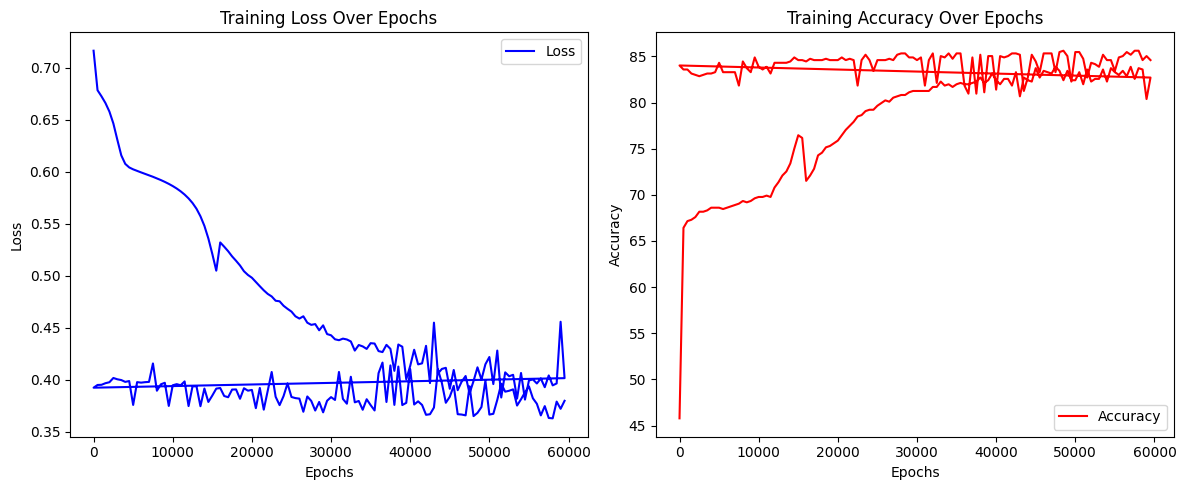

In [124]:
plot_side_by_side(epoch_arr, train_loss, train_accu, "Training")

#### Plotting Loss and Accuracy over epochs for Test Data

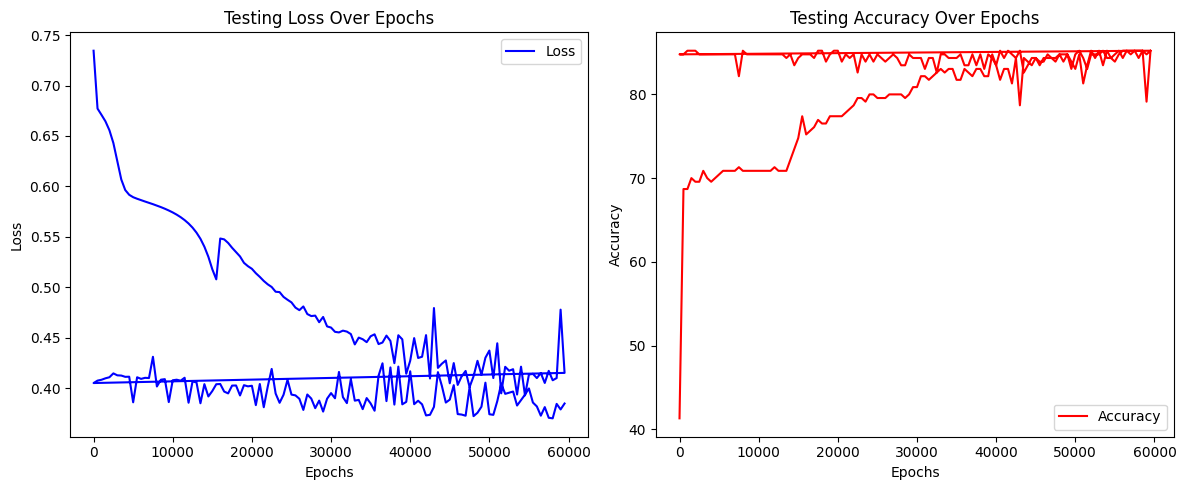

In [127]:
plot_side_by_side(epoch_arr, test_loss, test_accu, "Testing")

### Testing the model

In [370]:
model.eval()
with torch.inference_mode():
    test_output = model(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_output))

test_pred[:10], y_test[:10] 

(tensor([0., 0., 0., 0., 1., 0., 0., 1., 0., 1.]),
 tensor([0., 1., 0., 0., 1., 1., 0., 1., 0., 1.]))

### Calculating Metrics

In [371]:
accuracy = accuracy_score(y_test, test_pred)
precision = precision_score(y_test, test_pred)
recall = recall_score(y_test, test_pred)
f1 = f1_score(y_test, test_pred)

print(f'Accuracy: {accuracy*100:.2f}%')
print(f'Precision: {precision*100:.2f}')
print(f'Recall: {recall*100:.2f}')
print(f'F1 Score: {f1*100:.2f}')

Accuracy: 84.35%
Precision: 90.24
Recall: 82.22
F1 Score: 86.05


### Plotting Actual vs Predicted values

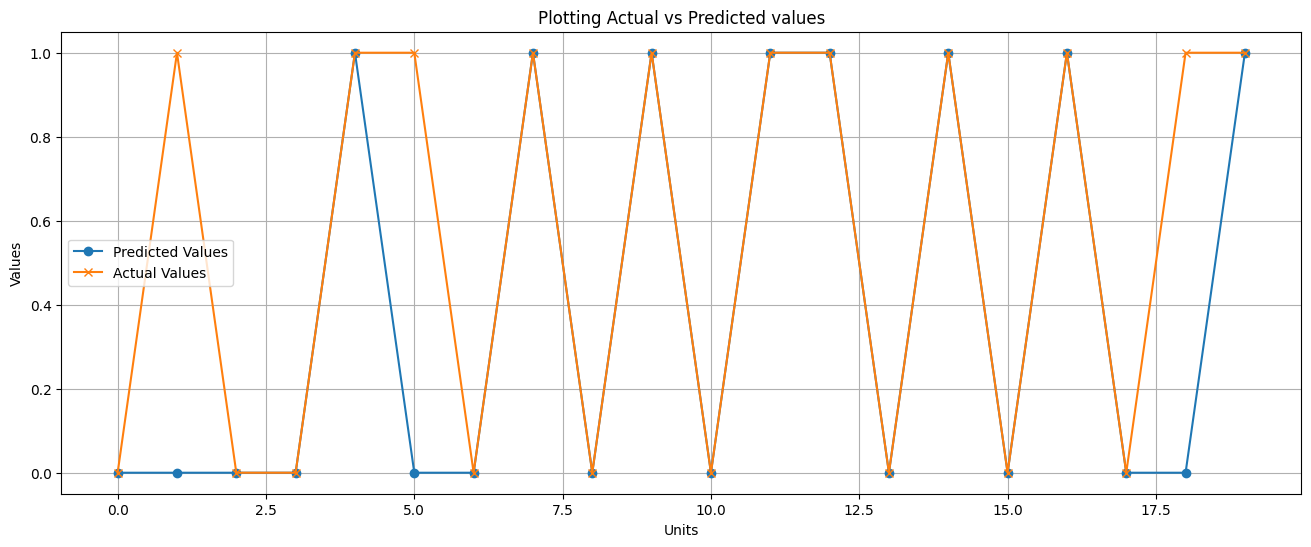

In [372]:
plt.figure(figsize=(16,6))
plt.plot(test_pred[:20], label='Predicted Values', marker='o')
plt.plot(y_test[:20], label='Actual Values', marker='x')
plt.title('Plotting Actual vs Predicted values')
plt.xlabel("Units")
plt.ylabel("Values")
plt.grid()
plt.legend()
plt.show()

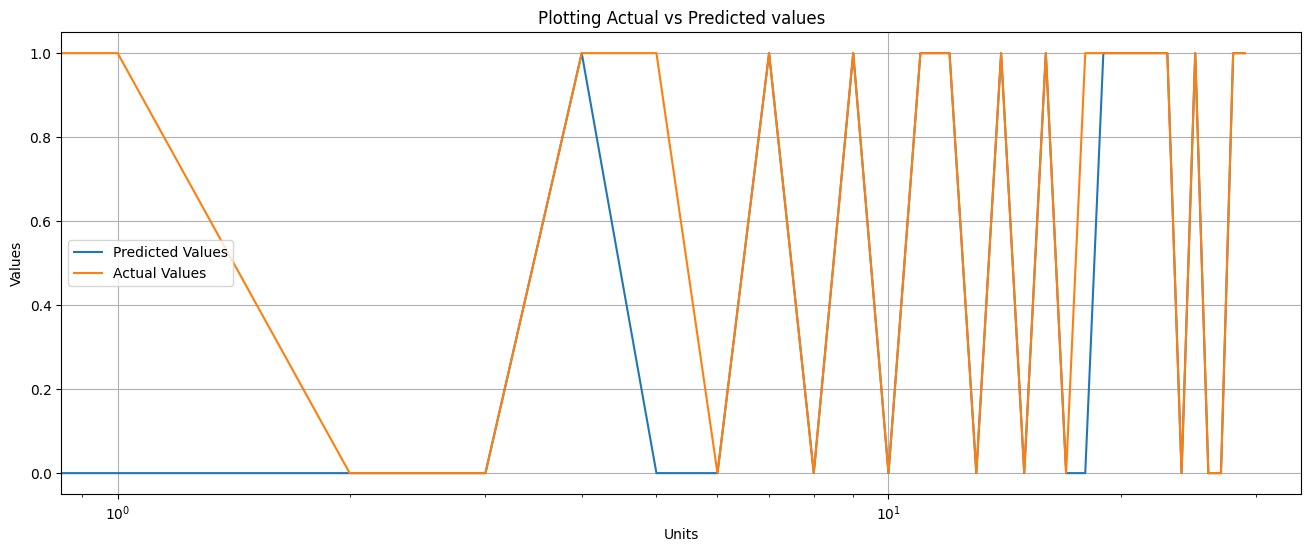

In [373]:
# scaled plot
plt.figure(figsize=(16,6))
plt.plot(test_pred[:30], label='Predicted Values')
plt.plot(y_test[:30], label='Actual Values')
plt.title('Plotting Actual vs Predicted values')
plt.xlabel("Units")
plt.ylabel("Values")
plt.xscale("log")
plt.grid()
plt.legend()
plt.show()